In [2]:
from __future__ import absolute_import, division, print_function

import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow.keras import layers

tf.VERSION

W0516 14:27:55.224029 140143959217984 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14


'1.12.0'

In [4]:
data_root = "/home/tom/Documents/bots/pictures"
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data = image_generator.flow_from_directory(str(data_root))

Found 84 images belonging to 2 classes.


In [6]:
for image_batch,label_batch in image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Label batch shape: ", label_batch.shape)
  break
print(data_root)

Image batch shape:  (32, 256, 256, 3)
Labe batch shape:  (32, 2)
/home/tom/Documents/bots/pictures


In [7]:
classifier_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/classification/2" #@param {type:"string"}
def classifier(x):
  classifier_module = hub.Module(classifier_url)
  return classifier_module(x)
  
IMAGE_SIZE = hub.get_expected_image_size(hub.Module(classifier_url))

In [8]:
feature_extractor_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/2" #@param {type:"string"}
def feature_extractor(x):
  feature_extractor_module = hub.Module(feature_extractor_url)
  return feature_extractor_module(x)

IMAGE_SIZE = hub.get_expected_image_size(hub.Module(feature_extractor_url))
image_data = image_generator.flow_from_directory(str(data_root), target_size=IMAGE_SIZE)
for image_batch,label_batch in image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Labe batch shape: ", label_batch.shape)
  break
features_extractor_layer = layers.Lambda(feature_extractor, input_shape=IMAGE_SIZE+[3])
features_extractor_layer.trainable = False


Found 84 images belonging to 2 classes.
Image batch shape:  (32, 224, 224, 3)
Labe batch shape:  (32, 2)


In [11]:
import tensorflow.keras.backend as K
sess = K.get_session()
init = tf.global_variables_initializer()

model = tf.keras.Sequential([
  features_extractor_layer,
  layers.Dense(image_data.num_classes, activation='softmax')
])
model.summary()
init = tf.global_variables_initializer()
sess.run(init)
result = model.predict(image_batch)
result.shape

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0516 14:37:06.703734 140143959217984 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 2562      
Total params: 2,562
Trainable params: 2,562
Non-trainable params: 0
_________________________________________________________________


(32, 2)

In [16]:
model.compile(
  optimizer=tf.train.AdamOptimizer(), 
  loss='categorical_crossentropy',
  metrics=['accuracy'])
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []
    
  def on_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
steps_per_epoch = image_data.samples//image_data.batch_size
batch_stats = CollectBatchStats()
model.fit((item for item in image_data), epochs=10, 
                    steps_per_epoch=steps_per_epoch,
                    callbacks = [batch_stats])

Epoch 1/10
2/2 [==============================] - 5s 3s/step - loss: 0.8678 - acc: 0.5000
Epoch 2/10
2/2 [==============================] - 0s 54ms/step - loss: 0.6856 - acc: 0.6010
Epoch 3/10
2/2 [==============================] - 0s 65ms/step - loss: 0.6335 - acc: 0.6250
Epoch 4/10
2/2 [==============================] - 0s 52ms/step - loss: 0.4630 - acc: 0.8361
Epoch 5/10
2/2 [==============================] - 0s 57ms/step - loss: 0.5233 - acc: 0.7332
Epoch 6/10
2/2 [==============================] - 1s 471ms/step - loss: 0.4559 - acc: 0.7812
Epoch 7/10
2/2 [==============================] - 1s 730ms/step - loss: 0.3496 - acc: 0.9034
Epoch 8/10
2/2 [==============================] - 1s 426ms/step - loss: 0.3741 - acc: 0.8865
Epoch 9/10
2/2 [==============================] - 1s 591ms/step - loss: 0.3237 - acc: 0.9219
Epoch 10/10
2/2 [==============================] - 1s 542ms/step - loss: 0.3221 - acc: 0.8803


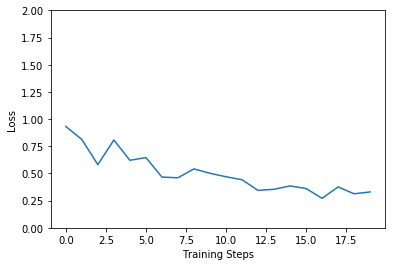

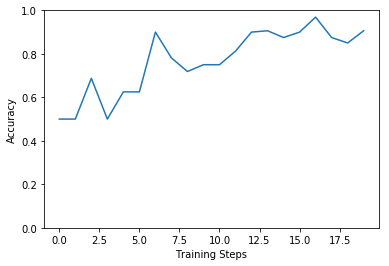

In [17]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats.batch_losses)

plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats.batch_acc)

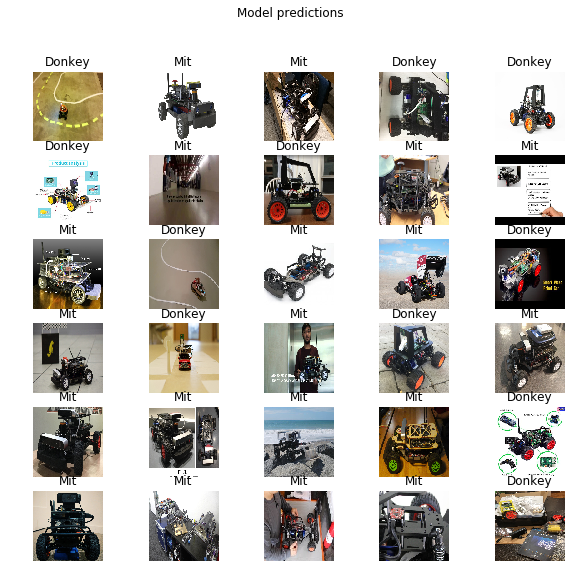

In [18]:
import numpy as np
import PIL.Image as Image
label_names = sorted(image_data.class_indices.items(), key=lambda pair:pair[1])
label_names = np.array([key.title() for key, value in label_names])
label_names
result_batch = model.predict(image_batch)

labels_batch = label_names[np.argmax(result_batch, axis=-1)]
labels_batch
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(labels_batch[n])
  plt.axis('off')
_ = plt.suptitle("Model predictions")

In [19]:
export_path = tf.contrib.saved_model.save_keras_model(model, "./saved_models")
export_path

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0516 14:50:04.998442 140143959217984 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Signatures INCLUDED in export for Classify: None


I0516 14:50:06.625666 140143959217984 tf_logging.py:115] Signatures INCLUDED in export for Classify: None


INFO:tensorflow:Signatures INCLUDED in export for Regress: None


I0516 14:50:06.626509 140143959217984 tf_logging.py:115] Signatures INCLUDED in export for Regress: None


INFO:tensorflow:Signatures INCLUDED in export for Predict: None


I0516 14:50:06.627093 140143959217984 tf_logging.py:115] Signatures INCLUDED in export for Predict: None


INFO:tensorflow:Signatures INCLUDED in export for Train: ['train']


I0516 14:50:06.627693 140143959217984 tf_logging.py:115] Signatures INCLUDED in export for Train: ['train']


INFO:tensorflow:Signatures INCLUDED in export for Eval: None


I0516 14:50:06.628332 140143959217984 tf_logging.py:115] Signatures INCLUDED in export for Eval: None


W0516 14:50:06.628997 140143959217984 tf_logging.py:120] Export includes no default signature!


INFO:tensorflow:No assets to save.


I0516 14:50:06.650002 140143959217984 tf_logging.py:115] No assets to save.


INFO:tensorflow:No assets to write.


I0516 14:50:06.650824 140143959217984 tf_logging.py:115] No assets to write.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0516 14:50:09.959653 140143959217984 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Signatures INCLUDED in export for Classify: None


I0516 14:50:11.030080 140143959217984 tf_logging.py:115] Signatures INCLUDED in export for Classify: None


INFO:tensorflow:Signatures INCLUDED in export for Regress: None


I0516 14:50:11.030968 140143959217984 tf_logging.py:115] Signatures INCLUDED in export for Regress: None


INFO:tensorflow:Signatures INCLUDED in export for Predict: None


I0516 14:50:11.031561 140143959217984 tf_logging.py:115] Signatures INCLUDED in export for Predict: None


INFO:tensorflow:Signatures INCLUDED in export for Train: None


I0516 14:50:11.032130 140143959217984 tf_logging.py:115] Signatures INCLUDED in export for Train: None


INFO:tensorflow:Signatures INCLUDED in export for Eval: ['eval']


I0516 14:50:11.032694 140143959217984 tf_logging.py:115] Signatures INCLUDED in export for Eval: ['eval']


W0516 14:50:11.033252 140143959217984 tf_logging.py:120] Export includes no default signature!


INFO:tensorflow:No assets to save.


I0516 14:50:11.050688 140143959217984 tf_logging.py:115] No assets to save.


INFO:tensorflow:No assets to write.


I0516 14:50:11.052101 140143959217984 tf_logging.py:115] No assets to write.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0516 14:50:13.860995 140143959217984 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Signatures INCLUDED in export for Classify: None


I0516 14:50:14.559842 140143959217984 tf_logging.py:115] Signatures INCLUDED in export for Classify: None


INFO:tensorflow:Signatures INCLUDED in export for Regress: None


I0516 14:50:14.560704 140143959217984 tf_logging.py:115] Signatures INCLUDED in export for Regress: None


INFO:tensorflow:Signatures INCLUDED in export for Predict: ['serving_default']


I0516 14:50:14.561718 140143959217984 tf_logging.py:115] Signatures INCLUDED in export for Predict: ['serving_default']


INFO:tensorflow:Signatures INCLUDED in export for Train: None


I0516 14:50:14.562402 140143959217984 tf_logging.py:115] Signatures INCLUDED in export for Train: None


INFO:tensorflow:Signatures INCLUDED in export for Eval: None


I0516 14:50:14.563132 140143959217984 tf_logging.py:115] Signatures INCLUDED in export for Eval: None


INFO:tensorflow:No assets to save.


I0516 14:50:14.578631 140143959217984 tf_logging.py:115] No assets to save.


INFO:tensorflow:No assets to write.


I0516 14:50:14.579448 140143959217984 tf_logging.py:115] No assets to write.


INFO:tensorflow:SavedModel written to: ./saved_models/temp-b'1557982200'/saved_model.pb


I0516 14:50:15.464509 140143959217984 tf_logging.py:115] SavedModel written to: ./saved_models/temp-b'1557982200'/saved_model.pb


b'./saved_models/1557982200'

In [20]:
model_prime = tf.contrib.saved_model.load_keras_model(export_path)
model_prime.summary()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0516 14:53:56.798243 140143959217984 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 2562      
Total params: 2,562
Trainable params: 2,562
Non-trainable params: 0
_________________________________________________________________


In [32]:
import tensorflow.keras.backend as K
sess = K.get_session()
init = tf.global_variables_initializer()

init = tf.global_variables_initializer()
sess.run(init)
# result = model.predict(image_batch)
# result.shape
label_names = sorted(image_data.class_indices.items(), key=lambda pair:pair[1])
label_names = np.array([key.title() for key, value in label_names])
print(label_names)
# predicted_class = np.argmax(result[0], axis=-1)
# predicted_class
grace_hopper = "/home/tom/Documents/bots/pictures/Donkey/hqdefault.jpg"
grace_hopper = Image.open(grace_hopper).resize(IMAGE_SIZE)
grace_hopper
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

result = model_prime.predict(grace_hopper[np.newaxis, ...])
result.shape
print(result[0])

# model_prime.predict('/home/tom/Documents/bots/pictures/MIT/03.jpg')

['Donkey' 'Mit']
[0.2279158 0.7720842]
